Our project is on classifying burn depth.  We started out using the dataset curated by Cohort 13.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import sys

from pathlib import Path
from fastai.vision import *
from fastai.callbacks import *
from google.colab import drive
from fastai import *

In [0]:
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/gdrive/My Drive')

# Assembling data

The data are organized with one label per folder; the labels represented are 1, 2, 3, and 'none'.

In [4]:
path = Path('/content/drive/My Drive/burn_nosplit_final/')
path.ls()

[PosixPath('/content/drive/My Drive/burn_nosplit_final/3'),
 PosixPath('/content/drive/My Drive/burn_nosplit_final/none'),
 PosixPath('/content/drive/My Drive/burn_nosplit_final/1'),
 PosixPath('/content/drive/My Drive/burn_nosplit_final/2'),
 PosixPath('/content/drive/My Drive/burn_nosplit_final/models')]

In [0]:
tfms = get_transforms(flip_vert=True)

In [0]:
data64 = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=tfms, size=64).normalize(imagenet_stats)
data128 = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=tfms, size=128).normalize(imagenet_stats)
data256 = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=tfms, size=256).normalize(imagenet_stats)

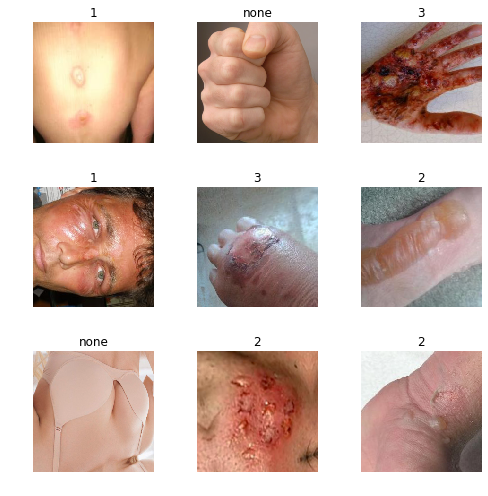

In [0]:
data256.show_batch(rows=3, figsize=(7, 7))

In [0]:
print(data64.classes)

['1', '2', '3', 'none']


# Training: ResNet-18

As a first step, I started training with ResNet-18 to get a lower bound on accuracy with a small model.  My initial strategy was to use smaller versions of the images to pre-train the network, and to gradually increase the size.  With this combination of image size and network, training goes pretty fast.  I was curious to see how long I could train for without overfitting (I've encountered in multiple places the advice to start training by *trying* to overfit your model), so I trained for 80 epochs, which still does not appear to be overfitting.  However, accuracy stopped improving after around epoch 30, so I trained for fewer epochs going forward.

After adding additional data augmentation, layer unfreezing, and TTA, the best accuracy was 0.8784

## Image size 64

In [64]:
learn1 = cnn_learner(data64, models.resnet18, metrics=accuracy).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 88997986.06it/s]


In [0]:
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


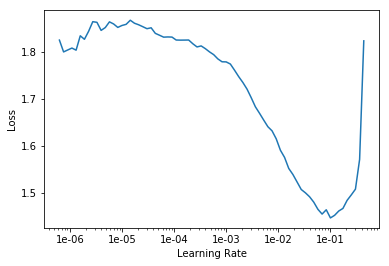

In [0]:
learn1.recorder.plot()

In [0]:
learn1.fit_one_cycle(50, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn1, every='improvement', monitor='accuracy', name='best_18_64')])

epoch,train_loss,valid_loss,accuracy,time
0,1.734880,1.248876,0.479730,00:07
1,1.607727,1.114025,0.540541,00:07
2,1.476931,1.033344,0.567568,00:07
3,1.385297,0.958670,0.601351,00:07
4,1.278334,0.909578,0.601351,00:07
5,1.205288,0.886994,0.635135,00:07
6,1.122291,0.875104,0.621622,00:07
7,1.065262,0.809347,0.655405,00:07
8,0.989779,0.756776,0.695946,00:07
9,0.928517,0.726832,0.750000,00:07


Better model found at epoch 0 with accuracy value: 0.4797297418117523.
Better model found at epoch 1 with accuracy value: 0.5405405163764954.
Better model found at epoch 2 with accuracy value: 0.5675675868988037.
Better model found at epoch 3 with accuracy value: 0.6013513803482056.
Better model found at epoch 5 with accuracy value: 0.6351351141929626.
Better model found at epoch 7 with accuracy value: 0.6554054021835327.
Better model found at epoch 8 with accuracy value: 0.6959459185600281.
Better model found at epoch 9 with accuracy value: 0.75.
Better model found at epoch 14 with accuracy value: 0.7635135054588318.
Better model found at epoch 30 with accuracy value: 0.7770270109176636.


In [65]:
learn1.load('best_18_64')

Learner(data=ImageDataBunch;

Train: LabelList (594 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
3,3,3,3,3
Path: /content/drive/My Drive/burn_nosplit_final;

Valid: LabelList (148 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,2,2,2,2
Path: /content/drive/My Drive/burn_nosplit_final;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

## Image size 128

I expected each increase in image size to be accompanied by an increase in accuracy, but image size 128 actually yielded the best model accuracy of ~0.865

In [0]:
learn1.data = data128
learn1.to_fp16

In [0]:
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


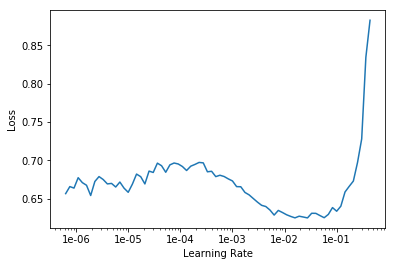

In [0]:
learn1.recorder.plot()

In [0]:
learn1.fit_one_cycle(40, 3e-3, pct_start=0.5, callbacks=[SaveModelCallback(learn1, every='improvement', monitor='accuracy', name='best_18_128')])

epoch,train_loss,valid_loss,accuracy,time
0,0.727370,0.531843,0.797297,00:09
1,0.705750,0.457465,0.824324,00:08
2,0.667155,0.440923,0.817568,00:09
3,0.636924,0.423763,0.831081,00:08
4,0.604959,0.405122,0.824324,00:08
5,0.586225,0.394570,0.844595,00:09
6,0.558517,0.382176,0.851351,00:08
7,0.537869,0.374221,0.837838,00:08
8,0.520114,0.363888,0.831081,00:08
9,0.503347,0.362775,0.837838,00:08


Better model found at epoch 0 with accuracy value: 0.7972972989082336.
Better model found at epoch 1 with accuracy value: 0.8243243098258972.
Better model found at epoch 3 with accuracy value: 0.8310810923576355.
Better model found at epoch 5 with accuracy value: 0.8445945978164673.
Better model found at epoch 6 with accuracy value: 0.8513513803482056.
Better model found at epoch 14 with accuracy value: 0.8581081032752991.
Better model found at epoch 18 with accuracy value: 0.8648648858070374.


## Image size 256

In [0]:
learn1.to_fp32()
learn1.data = data256
learn1.load('best_18_128')
learn1.to_fp16()

In [0]:
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


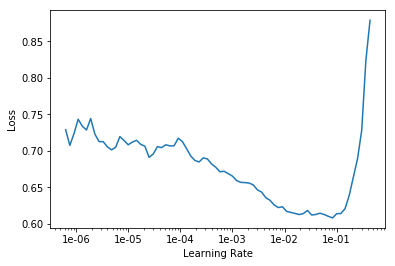

In [0]:
learn1.recorder.plot()

In [0]:
learn1.fit_one_cycle(40, 3e-3, pct_start=0.5, callbacks=[SaveModelCallback(learn1, every='improvement', monitor='accuracy', name='best_18_256')])

epoch,train_loss,valid_loss,accuracy,time
0,0.666796,0.403428,0.824324,00:13
1,0.649503,0.437225,0.810811,00:13
2,0.636198,0.452520,0.810811,00:12
3,0.618739,0.451481,0.810811,00:13
4,0.600862,0.435988,0.824324,00:13
5,0.585757,0.420021,0.831081,00:13
6,0.554067,0.398346,0.831081,00:13
7,0.530316,0.394140,0.817568,00:12
8,0.518696,0.390251,0.824324,00:12
9,0.493996,0.385526,0.831081,00:12


Better model found at epoch 0 with accuracy value: 0.8243243098258972.
Better model found at epoch 5 with accuracy value: 0.8310810923576355.
Better model found at epoch 12 with accuracy value: 0.8445945978164673.
Better model found at epoch 14 with accuracy value: 0.8513513803482056.


## Adding mixup

In [0]:
learn1.load('best_18_128')
learn1 = learn1.mixup()

In [0]:
learn1.fit_one_cycle(40, 3e-3, pct_start=0.5, callbacks=[SaveModelCallback(learn1, every='improvement', monitor='accuracy', name='best_18_256')])

epoch,train_loss,valid_loss,accuracy,time
0,1.198177,0.398806,0.817568,00:13
1,1.252194,0.431513,0.824324,00:13
2,1.235662,0.453456,0.824324,00:12
3,1.182896,0.458101,0.810811,00:12
4,1.163288,0.460897,0.790541,00:12
5,1.119845,0.452443,0.790541,00:13
6,1.080519,0.455264,0.810811,00:12
7,1.029485,0.447036,0.817568,00:12
8,1.002484,0.456573,0.831081,00:12
9,0.965654,0.453340,0.824324,00:12


Better model found at epoch 0 with accuracy value: 0.8175675868988037.
Better model found at epoch 1 with accuracy value: 0.8243243098258972.
Better model found at epoch 8 with accuracy value: 0.8310810923576355.
Better model found at epoch 19 with accuracy value: 0.837837815284729.


## Layer unfreezing

I did not get any better results from layer unfreezing.

In [0]:
learn1.load('best_18_128')
learn1.freeze_to(-1)
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


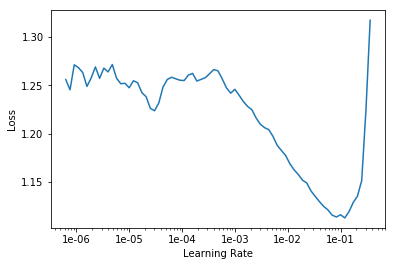

In [0]:
learn1.recorder.plot()

In [0]:
learn1.fit_one_cycle(40, slice(1e-3, 1e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn1, every='improvement', monitor='accuracy', name='best_18_256')])

epoch,train_loss,valid_loss,accuracy,time
0,1.305188,0.393832,0.831081,00:12
1,1.250027,0.426738,0.804054,00:13
2,1.200470,0.456388,0.804054,00:13
3,1.146197,0.492268,0.797297,00:13
4,1.094952,0.539420,0.777027,00:14
5,1.045041,0.565795,0.770270,00:12
6,0.997895,0.514776,0.804054,00:13
7,0.956494,0.490384,0.797297,00:13
8,0.924075,0.482038,0.797297,00:12
9,0.897310,0.489268,0.797297,00:12


Better model found at epoch 0 with accuracy value: 0.8310810923576355.
Better model found at epoch 12 with accuracy value: 0.837837815284729.


## Adding TTA

TTA takes a scale argument that can affect how well it works, so I tried several different values.  The best result was with scale=0.95, which gave an accuracy of 0.8784

In [0]:
learn1.to_fp32()

In [0]:
accs = []
for i in np.arange(0.9, 1.5, 0.05):
   accs.append((i, accuracy(*learn1.TTA(scale=i))))

In [0]:
for a in accs:
  print(a[0], a[1].item())

0.9 0.8581081032752991
0.9500000000000001 0.8783783912658691
1.0 0.8581081032752991
1.0500000000000003 0.8648648858070374
1.1 0.8513513803482056
1.1500000000000004 0.8581081032752991
1.2000000000000002 0.8445945978164673
1.2500000000000004 0.8445945978164673
1.3000000000000003 0.8513513803482056
1.3500000000000005 0.8445945978164673
1.4000000000000004 0.837837815284729
1.4500000000000006 0.8310810923576355


# Now trying with ResNet-34

Best accuracy was  0.8851

## Image size 64

In [0]:
learn2 = cnn_learner(data64, models.resnet34, metrics=accuracy).to_fp16().mixup()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 131332694.82it/s]


In [0]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


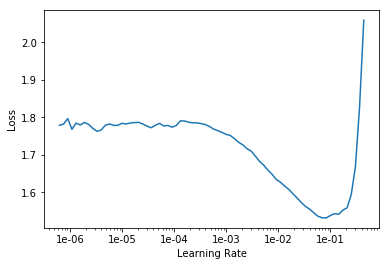

In [0]:
learn2.recorder.plot()

In [0]:
learn2.fit_one_cycle(50, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn2, every='improvement', monitor='accuracy', name='best_34_64')])

epoch,train_loss,valid_loss,accuracy,time
0,1.694740,1.388423,0.405405,00:07
1,1.606339,1.105823,0.574324,00:07
2,1.523063,0.945355,0.621622,00:07
3,1.465992,0.863933,0.641892,00:07
4,1.401103,0.814388,0.682432,00:07
5,1.338655,0.795746,0.682432,00:07
6,1.297180,0.798533,0.689189,00:07
7,1.266614,0.789757,0.709459,00:07
8,1.232054,0.774331,0.695946,00:07
9,1.194730,0.798181,0.675676,00:07


Better model found at epoch 0 with accuracy value: 0.4054054021835327.
Better model found at epoch 1 with accuracy value: 0.5743243098258972.
Better model found at epoch 2 with accuracy value: 0.6216216087341309.
Better model found at epoch 3 with accuracy value: 0.6418918967247009.
Better model found at epoch 4 with accuracy value: 0.6824324131011963.
Better model found at epoch 6 with accuracy value: 0.6891891956329346.
Better model found at epoch 7 with accuracy value: 0.7094594836235046.
Better model found at epoch 14 with accuracy value: 0.7162162065505981.
Better model found at epoch 15 with accuracy value: 0.7297297120094299.
Better model found at epoch 21 with accuracy value: 0.7432432174682617.
Better model found at epoch 28 with accuracy value: 0.75.
Better model found at epoch 30 with accuracy value: 0.7905405163764954.
Better model found at epoch 32 with accuracy value: 0.8108108043670654.


## Image size 128

In [0]:
learn2.to_fp32()
learn2.data = data128
learn2.to_fp16()
learn2.load('best_34_64')
learn2.lr_find()

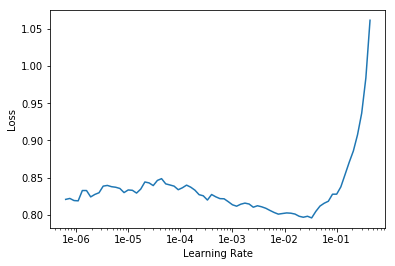

In [0]:
learn2.recorder.plot()

In [0]:
learn2.fit_one_cycle(50, 3e-3, pct_start=0.5, callbacks=[SaveModelCallback(learn2, every='improvement', monitor='accuracy', name='best_34_128')])

epoch,train_loss,valid_loss,accuracy,time
0,0.834395,0.644581,0.736486,00:07
1,0.848524,0.619614,0.763514,00:08
2,0.829450,0.612867,0.756757,00:08
3,0.824628,0.599348,0.770270,00:08
4,0.822530,0.586880,0.777027,00:08
5,0.811542,0.567823,0.783784,00:09
6,0.801527,0.559640,0.797297,00:09
7,0.793857,0.553388,0.804054,00:08
8,0.785635,0.542689,0.797297,00:08
9,0.763982,0.543074,0.797297,00:08


Better model found at epoch 0 with accuracy value: 0.7364864945411682.
Better model found at epoch 1 with accuracy value: 0.7635135054588318.
Better model found at epoch 3 with accuracy value: 0.7702702879905701.
Better model found at epoch 4 with accuracy value: 0.7770270109176636.
Better model found at epoch 5 with accuracy value: 0.7837837934494019.
Better model found at epoch 6 with accuracy value: 0.7972972989082336.
Better model found at epoch 7 with accuracy value: 0.8040540814399719.
Better model found at epoch 13 with accuracy value: 0.8108108043670654.
Better model found at epoch 17 with accuracy value: 0.8175675868988037.
Better model found at epoch 19 with accuracy value: 0.8243243098258972.
Better model found at epoch 20 with accuracy value: 0.8310810923576355.


In [0]:
learn2.to_fp32()
learn2.data = data256
learn2.to_fp16()
learn2.load('best_34_128')
learn2.lr_find()

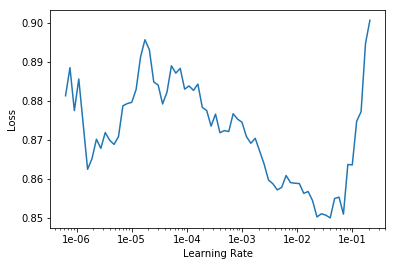

In [0]:
learn2.recorder.plot(skip_end=10)

In [0]:
learn2.fit_one_cycle(30, 3e-3, pct_start=0.5, callbacks=[SaveModelCallback(learn2, every='improvement', monitor='accuracy', name='best_34_256')])

epoch,train_loss,valid_loss,accuracy,time
0,0.828506,0.443240,0.837838,00:12
1,0.799124,0.444494,0.844595,00:12
2,0.807790,0.447763,0.844595,00:12
3,0.810952,0.464575,0.837838,00:12
4,0.799567,0.464551,0.824324,00:12
5,0.797100,0.461380,0.810811,00:13
6,0.797568,0.449613,0.824324,00:12
7,0.783062,0.431464,0.804054,00:12
8,0.771213,0.400990,0.824324,00:12
9,0.763937,0.431925,0.817568,00:12


Better model found at epoch 0 with accuracy value: 0.837837815284729.
Better model found at epoch 1 with accuracy value: 0.8445945978164673.


In [0]:
learn2.freeze_to(-1)
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


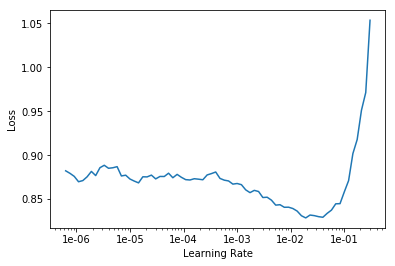

In [0]:
learn2.recorder.plot()

In [0]:
learn2.fit_one_cycle(30, slice(1e-3, 1e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn2, every='improvement', monitor='accuracy', name='best_34_256_1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.820754,0.456904,0.831081,00:13
1,0.816581,0.462612,0.831081,00:12
2,0.791956,0.452311,0.831081,00:12
3,0.796948,0.449357,0.824324,00:12
4,0.786212,0.463219,0.797297,00:14
5,0.771600,0.446844,0.824324,00:12
6,0.761863,0.431046,0.824324,00:13
7,0.761595,0.475081,0.804054,00:13
8,0.759627,0.405770,0.864865,00:12
9,0.751473,0.427000,0.824324,00:12


Better model found at epoch 0 with accuracy value: 0.8310810923576355.
Better model found at epoch 8 with accuracy value: 0.8648648858070374.


In [0]:
learn2.load('best_34_256_1')

## Adding TTA

With TTA and scale=1 or 1.1, we have accuracy 0.8851

In [0]:
learn2.to_fp32()

In [0]:
accuracy(*learn2.get_preds())

tensor(0.8649)

In [0]:
accs34 = []
for i in np.arange(0.9, 1.5, 0.05):
   accs34.append((i, accuracy(*learn2.TTA(scale=i))))

In [0]:
for a in accs34:
  print(a[0], a[1].item())

0.9 0.8648648858070374
0.9500000000000001 0.8716216087341309
1.0 0.8851351141929626
1.0500000000000003 0.8783783912658691
1.1 0.8851351141929626
1.1500000000000004 0.8716216087341309
1.2000000000000002 0.8648648858070374
1.2500000000000004 0.8716216087341309
1.3000000000000003 0.8783783912658691
1.3500000000000005 0.8716216087341309
1.4000000000000004 0.8445945978164673
1.4500000000000006 0.8783783912658691


In [0]:
sorted(accs34, key=lambda a: a[1], reverse=True)

[(1.0, tensor(0.8851)),
 (1.1, tensor(0.8851)),
 (1.0500000000000003, tensor(0.8784)),
 (1.3000000000000003, tensor(0.8784)),
 (1.4500000000000006, tensor(0.8784)),
 (0.9500000000000001, tensor(0.8716)),
 (1.1500000000000004, tensor(0.8716)),
 (1.2500000000000004, tensor(0.8716)),
 (1.3500000000000005, tensor(0.8716)),
 (0.9, tensor(0.8649)),
 (1.2000000000000002, tensor(0.8649)),
 (1.4000000000000004, tensor(0.8446))]

# Now trying ResNet 50

With TTA, we get 0.8649 accuracy

In [0]:
learn3 = cnn_learner(data64, models.resnet50, metrics=accuracy).to_fp16().mixup()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 92013569.48it/s]


In [0]:
learn3.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


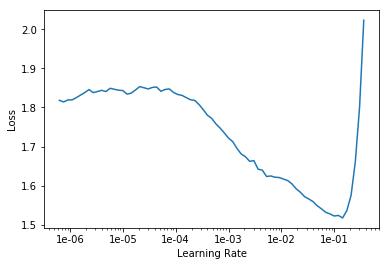

In [0]:
learn3.recorder.plot()

In [0]:
learn3.fit_one_cycle(40, 3e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn3, every='improvement', monitor='accuracy', name='best_50_64')])

epoch,train_loss,valid_loss,accuracy,time
0,1.642842,1.034921,0.641892,00:07
1,1.501152,0.997386,0.689189,00:07
2,1.397769,0.972328,0.628378,00:07
3,1.307291,1.024271,0.662162,00:08
4,1.221208,0.867627,0.716216,00:07
5,1.167850,0.850504,0.662162,00:07
6,1.124956,0.861828,0.675676,00:07
7,1.078469,0.947326,0.648649,00:07
8,1.044008,0.738092,0.662162,00:07
9,1.011583,0.947714,0.662162,00:07


Better model found at epoch 0 with accuracy value: 0.6418918967247009.
Better model found at epoch 1 with accuracy value: 0.6891891956329346.
Better model found at epoch 4 with accuracy value: 0.7162162065505981.
Better model found at epoch 25 with accuracy value: 0.7297297120094299.
Better model found at epoch 29 with accuracy value: 0.7635135054588318.
Better model found at epoch 33 with accuracy value: 0.7702702879905701.
Better model found at epoch 34 with accuracy value: 0.7770270109176636.
Better model found at epoch 35 with accuracy value: 0.7905405163764954.


In [0]:
learn3.to_fp32()
learn3.data = data128
learn3.to_fp16()
learn3.load('best_50_64')
learn3.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


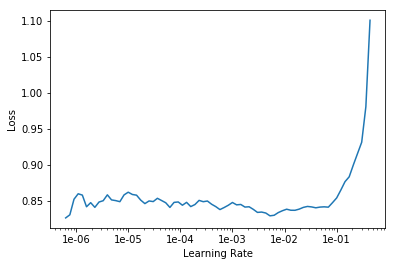

In [0]:
learn3.recorder.plot()

In [0]:
learn3.fit_one_cycle(40, 3e-3, pct_start=0.5, callbacks=[SaveModelCallback(learn3, every='improvement', monitor='accuracy', name='best_50_128')])

epoch,train_loss,valid_loss,accuracy,time
0,0.866111,0.568396,0.790541,00:09
1,0.833471,0.570573,0.790541,00:09
2,0.840608,0.564284,0.797297,00:09
3,0.820108,0.552831,0.810811,00:09
4,0.811323,0.545357,0.804054,00:08
5,0.790779,0.546467,0.804054,00:08
6,0.780911,0.541192,0.797297,00:08
7,0.771278,0.533345,0.804054,00:08
8,0.769948,0.533381,0.810811,00:08
9,0.759032,0.545641,0.783784,00:08


Better model found at epoch 0 with accuracy value: 0.7905405163764954.
Better model found at epoch 2 with accuracy value: 0.7972972989082336.
Better model found at epoch 3 with accuracy value: 0.8108108043670654.


In [0]:
learn3.to_fp32()
learn3.data = data256
learn3.to_fp16()
learn3.load('best_50_128')
learn3.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


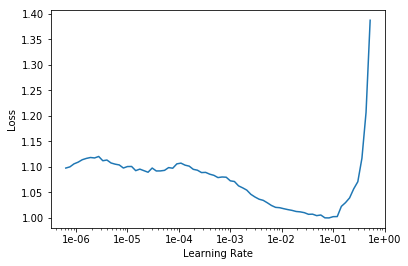

In [0]:
learn3.recorder.plot()

In [0]:
learn3.fit_one_cycle(40, 3e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn3, every='improvement', monitor='accuracy', name='best_50_256')])

epoch,train_loss,valid_loss,accuracy,time
0,0.976430,0.737976,0.743243,00:13
1,0.934737,0.696096,0.729730,00:12
2,0.923779,0.641516,0.756757,00:13
3,0.907518,0.595292,0.743243,00:13
4,0.889083,0.566006,0.756757,00:13
5,0.858997,0.466322,0.783784,00:13
6,0.836798,0.496631,0.783784,00:13
7,0.826625,0.469117,0.817568,00:13
8,0.813917,0.544232,0.777027,00:14
9,0.808259,0.923195,0.695946,00:13


Better model found at epoch 0 with accuracy value: 0.7432432174682617.
Better model found at epoch 2 with accuracy value: 0.7567567825317383.
Better model found at epoch 5 with accuracy value: 0.7837837934494019.
Better model found at epoch 7 with accuracy value: 0.8175675868988037.
Better model found at epoch 27 with accuracy value: 0.8243243098258972.
Better model found at epoch 31 with accuracy value: 0.8513513803482056.


In [0]:
learn3.load('best_50_256')
learn3.freeze_to(-1)
learn3.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


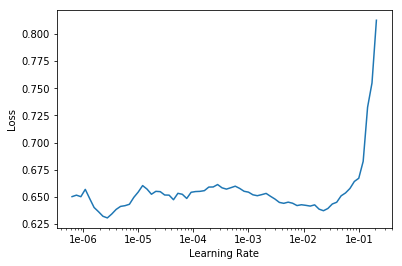

In [0]:
learn3.recorder.plot()

In [0]:
learn3.fit_one_cycle(40, slice(1e-3, 1e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn3, every='improvement', monitor='accuracy', name='best_50_256_1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.617717,0.485431,0.831081,00:12
1,0.631819,0.492633,0.824324,00:14
2,0.620448,0.491447,0.817568,00:13
3,0.623326,0.501276,0.817568,00:13
4,0.635330,0.501480,0.810811,00:12
5,0.635513,0.510527,0.804054,00:13
6,0.636728,0.495934,0.817568,00:13
7,0.630538,0.488703,0.817568,00:14
8,0.622647,0.475808,0.824324,00:12
9,0.617231,0.469266,0.817568,00:12


Better model found at epoch 0 with accuracy value: 0.8310810923576355.
Better model found at epoch 19 with accuracy value: 0.8513513803482056.


## Adding TTA

In [0]:
learn3.load('best_50_256_1')
learn3.to_fp32()

In [0]:
accs50 = []
for i in np.arange(0.9, 1.4, 0.05):
   accs50.append((i, accuracy(*learn3.TTA(scale=i))))

In [0]:
sorted(accs50, key=lambda a: a[1], reverse=True)

[(1.1, tensor(0.8649)),
 (1.3500000000000005, tensor(0.8581)),
 (0.9500000000000001, tensor(0.8514)),
 (1.0, tensor(0.8514)),
 (1.0500000000000003, tensor(0.8514)),
 (1.2000000000000002, tensor(0.8514)),
 (1.2500000000000004, tensor(0.8514)),
 (1.3000000000000003, tensor(0.8514)),
 (0.9, tensor(0.8446)),
 (1.1500000000000004, tensor(0.8446))]

# With ResNet-152

Best result with TTA: 0.858

In [7]:
learn4 = cnn_learner(data64, models.resnet50, metrics=accuracy).to_fp16().mixup()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 27579073.07it/s]


In [0]:
learn4.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


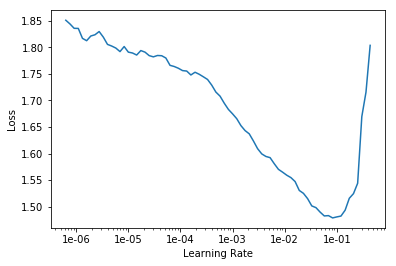

In [0]:
learn4.recorder.plot()

In [8]:
learn4.fit_one_cycle(50, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn4, every='improvement', monitor='accuracy', name='best_152_64')])

epoch,train_loss,valid_loss,accuracy,time
0,1.603596,1.107415,0.547297,02:38
1,1.444368,1.111863,0.614865,00:11
2,1.358988,1.147827,0.648649,00:07
3,1.297630,1.100850,0.668919,00:08
4,1.254840,1.007954,0.675676,00:07
5,1.220729,1.059755,0.641892,00:07
6,1.187112,1.118474,0.641892,00:07
7,1.140563,0.966018,0.655405,00:07
8,1.102172,0.957175,0.675676,00:07
9,1.061230,0.934331,0.662162,00:07


Better model found at epoch 0 with accuracy value: 0.5472972989082336.
Better model found at epoch 1 with accuracy value: 0.6148648858070374.
Better model found at epoch 2 with accuracy value: 0.6486486196517944.
Better model found at epoch 3 with accuracy value: 0.6689189076423645.
Better model found at epoch 4 with accuracy value: 0.6756756901741028.
Better model found at epoch 10 with accuracy value: 0.6824324131011963.
Better model found at epoch 27 with accuracy value: 0.6959459185600281.
Better model found at epoch 28 with accuracy value: 0.7432432174682617.


In [0]:
learn4.to_fp32()
learn4.data = data128
learn4.to_fp16()
learn4.load('best_152_64')
learn4.lr_find()

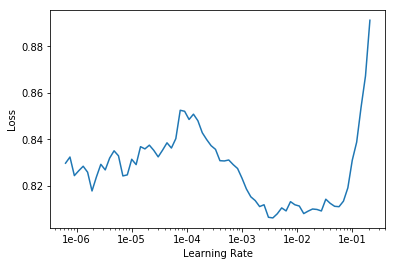

In [0]:
learn4.recorder.plot(skip_end=10)

In [10]:
learn4.fit_one_cycle(50, 1e-3, pct_start=0.5, callbacks=[SaveModelCallback(learn4, every='improvement', monitor='accuracy', name='best_152_128')])

epoch,train_loss,valid_loss,accuracy,time
0,0.883543,0.400402,0.858108,00:10
1,0.874864,0.384567,0.858108,00:08
2,0.857321,0.382110,0.851351,00:09
3,0.852063,0.378944,0.844595,00:09
4,0.837856,0.377293,0.844595,00:08
5,0.833193,0.373536,0.851351,00:08
6,0.829151,0.375000,0.864865,00:08
7,0.831280,0.383618,0.851351,00:08
8,0.825270,0.393534,0.844595,00:08
9,0.809306,0.390362,0.851351,00:08


Better model found at epoch 0 with accuracy value: 0.8581081032752991.
Better model found at epoch 6 with accuracy value: 0.8648648858070374.
Better model found at epoch 14 with accuracy value: 0.8716216087341309.
Better model found at epoch 15 with accuracy value: 0.8851351141929626.


In [0]:
learn4.to_fp32()
learn4.data = data256
learn4.to_fp16()
learn4.load('best_152_128')
learn4.lr_find()

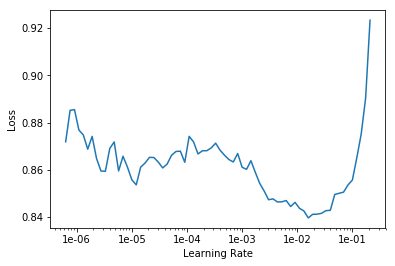

In [0]:
learn4.recorder.plot(skip_end=10)

In [12]:
learn4.fit_one_cycle(50, 3e-3, pct_start=0.5, callbacks=[SaveModelCallback(learn4, every='improvement', monitor='accuracy', name='best_152_256')])

epoch,train_loss,valid_loss,accuracy,time
0,0.881860,0.574399,0.777027,00:14
1,0.863635,0.569173,0.743243,00:13
2,0.833616,0.559523,0.750000,00:13
3,0.833486,0.544148,0.750000,00:13
4,0.832673,0.547896,0.756757,00:13
5,0.826574,0.536005,0.763514,00:13
6,0.818305,0.531247,0.763514,00:13
7,0.801150,0.520904,0.756757,00:13
8,0.786157,0.521729,0.750000,00:13
9,0.772100,0.506874,0.777027,00:13


Better model found at epoch 0 with accuracy value: 0.7770270109176636.
Better model found at epoch 10 with accuracy value: 0.7837837934494019.
Better model found at epoch 12 with accuracy value: 0.7972972989082336.
Better model found at epoch 39 with accuracy value: 0.8040540814399719.


In [15]:
learn4.load('best_152_128')
learn4.freeze_to(-1)
learn4.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


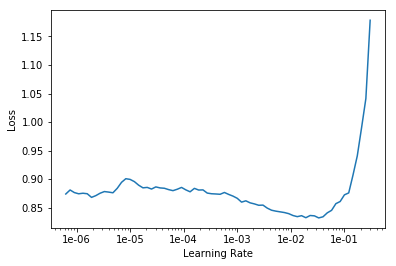

In [16]:
learn4.recorder.plot()

In [17]:
learn4.fit_one_cycle(50, slice(1e-3, 1e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn4, every='improvement', monitor='accuracy', name='best_152_256_1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.866048,0.568448,0.770270,00:12
1,0.849302,0.546896,0.756757,00:14
2,0.833095,0.540681,0.763514,00:13
3,0.828870,0.535954,0.756757,00:13
4,0.814970,0.528598,0.763514,00:14
5,0.808615,0.511774,0.783784,00:12
6,0.799804,0.521191,0.770270,00:13
7,0.787226,0.530975,0.756757,00:14
8,0.775309,0.546142,0.743243,00:13
9,0.761800,0.549283,0.790541,00:13


Better model found at epoch 0 with accuracy value: 0.7702702879905701.
Better model found at epoch 5 with accuracy value: 0.7837837934494019.
Better model found at epoch 9 with accuracy value: 0.7905405163764954.
Better model found at epoch 22 with accuracy value: 0.8175675868988037.


In [0]:
learn4.load('best_152_128')
learn4.to_fp32()

In [22]:
accs152 = []
for i in np.arange(0.7, 0.9, 0.05):
   accs152.append((i, accuracy(*learn4.TTA(scale=i))))

In [23]:
sorted(accs152, key=lambda a: a[1], reverse=True)

[(0.75, tensor(0.8581)),
 (0.8, tensor(0.8446)),
 (0.8500000000000001, tensor(0.8446)),
 (0.7, tensor(0.8378)),
 (0.9000000000000001, tensor(0.8378))]

# DenseNet-161

Best accuracy (with TTA): 0.9459

In [24]:
learn5 = cnn_learner(data64, models.densenet161, metrics=accuracy).mixup().to_fp16()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:07<00:00, 14817148.19it/s]


In [25]:
learn5.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


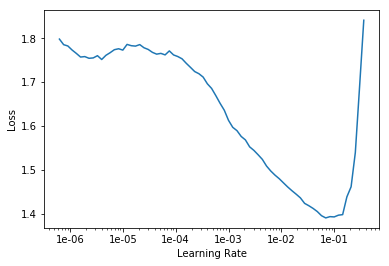

In [26]:
learn5.recorder.plot()

In [27]:
learn5.fit_one_cycle(50, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn5, every='improvement', monitor='accuracy', name='best_161_64')])

epoch,train_loss,valid_loss,accuracy,time
0,1.581849,1.135271,0.533784,00:10
1,1.381228,0.977246,0.635135,00:07
2,1.273155,0.894660,0.641892,00:08
3,1.168206,0.884546,0.648649,00:08
4,1.080528,0.845821,0.635135,00:08
5,1.039824,0.914591,0.621622,00:09
6,0.993783,0.875767,0.608108,00:08
7,0.965587,0.858776,0.675676,00:08
8,0.941895,0.824335,0.702703,00:08
9,0.907750,0.900684,0.702703,00:08


Better model found at epoch 0 with accuracy value: 0.5337837934494019.
Better model found at epoch 1 with accuracy value: 0.6351351141929626.
Better model found at epoch 2 with accuracy value: 0.6418918967247009.
Better model found at epoch 3 with accuracy value: 0.6486486196517944.
Better model found at epoch 7 with accuracy value: 0.6756756901741028.
Better model found at epoch 8 with accuracy value: 0.7027027010917664.
Better model found at epoch 15 with accuracy value: 0.7432432174682617.
Better model found at epoch 17 with accuracy value: 0.75.
Better model found at epoch 28 with accuracy value: 0.7567567825317383.
Better model found at epoch 40 with accuracy value: 0.7702702879905701.


In [31]:
learn5.to_fp32()
learn5.data = data128
learn5.to_fp16()
learn5.load('best_161_64')
learn5.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


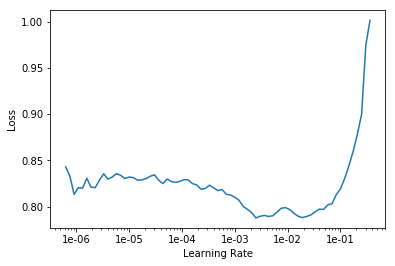

In [32]:
learn5.recorder.plot()

In [33]:
learn5.fit_one_cycle(50, 3e-3, pct_start=0.5, callbacks=[SaveModelCallback(learn5, every='improvement', monitor='accuracy', name='best_161_128')])

epoch,train_loss,valid_loss,accuracy,time
0,0.823443,0.328408,0.918919,00:10
1,0.819834,0.310222,0.905405,00:10
2,0.778916,0.307439,0.905405,00:09
3,0.761883,0.312135,0.912162,00:09
4,0.750645,0.319390,0.905405,00:09
5,0.732629,0.327255,0.905405,00:09
6,0.719069,0.316029,0.912162,00:09
7,0.712497,0.300364,0.905405,00:09
8,0.693540,0.305956,0.912162,00:09
9,0.682453,0.295345,0.932432,00:10


Better model found at epoch 0 with accuracy value: 0.9189189076423645.
Better model found at epoch 9 with accuracy value: 0.9324324131011963.


In [0]:
learn5.save('best_161_current')

In [36]:
learn5.to_fp32()
learn5.data = data256
learn5.to_fp16()
learn5.load('best_161_128')
learn5.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


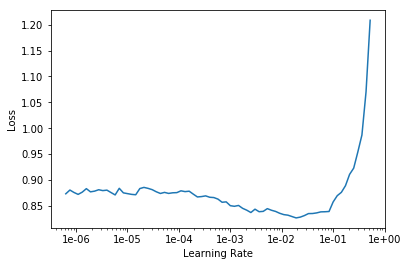

In [37]:
learn5.recorder.plot()

In [38]:
learn5.fit_one_cycle(50, 3e-3, pct_start=0.5, callbacks=[SaveModelCallback(learn5, every='improvement', monitor='accuracy', name='best_161_256')])

epoch,train_loss,valid_loss,accuracy,time
0,0.827508,0.576970,0.743243,00:16
1,0.840643,0.518176,0.777027,00:15
2,0.826894,0.504363,0.804054,00:15
3,0.814544,0.495023,0.810811,00:16
4,0.793248,0.481673,0.810811,00:15
5,0.777499,0.483745,0.797297,00:15
6,0.764424,0.474981,0.804054,00:15
7,0.754461,0.468477,0.804054,00:15
8,0.735092,0.495660,0.797297,00:16
9,0.716230,0.500773,0.790541,00:15


Better model found at epoch 0 with accuracy value: 0.7432432174682617.
Better model found at epoch 1 with accuracy value: 0.7770270109176636.
Better model found at epoch 2 with accuracy value: 0.8040540814399719.
Better model found at epoch 3 with accuracy value: 0.8108108043670654.
Better model found at epoch 13 with accuracy value: 0.837837815284729.


In [39]:
learn5.to_fp32()
learn5.data = data128
learn5.to_fp16()
learn5.load('best_161_128')
learn5.freeze_to(-1)
learn5.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


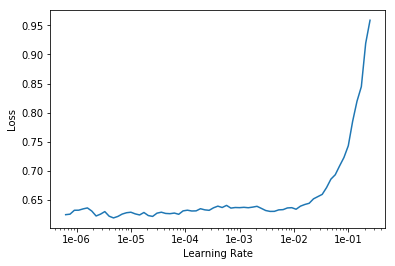

In [40]:
learn5.recorder.plot()

In [41]:
learn5.fit_one_cycle(50, slice(1e-4, 1e-3), pct_start=0.5, callbacks=[SaveModelCallback(learn5, every='improvement', monitor='accuracy', name='best_161_128_1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.635394,0.296113,0.925676,00:10
1,0.631887,0.292320,0.925676,00:09
2,0.628775,0.287812,0.925676,00:09
3,0.616955,0.289094,0.918919,00:09
4,0.615757,0.291958,0.925676,00:09
5,0.609382,0.291128,0.925676,00:09
6,0.603260,0.290262,0.918919,00:09
7,0.602003,0.292139,0.918919,00:09
8,0.614117,0.286877,0.925676,00:10
9,0.607675,0.291325,0.932432,00:09


Better model found at epoch 0 with accuracy value: 0.9256756901741028.
Better model found at epoch 9 with accuracy value: 0.9324324131011963.


In [42]:
learn5.load('best_161_128')
learn5.to_fp32()

Learner(data=ImageDataBunch;

Train: LabelList (594 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
3,3,3,3,3
Path: /content/drive/My Drive/burn_nosplit_final;

Valid: LabelList (148 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
none,1,3,1,1
Path: /content/drive/My Drive/burn_nosplit_final;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_runn

In [43]:
accs161 = []
for i in np.arange(0.7, 1.4, 0.05):
   accs161.append((i, accuracy(*learn5.TTA(scale=i))))

In [44]:
sorted(accs161, key=lambda a:a[1], reverse=True)

[(1.0500000000000003, tensor(0.9459)),
 (0.75, tensor(0.9392)),
 (0.8500000000000001, tensor(0.9392)),
 (0.9000000000000001, tensor(0.9392)),
 (1.1000000000000003, tensor(0.9392)),
 (0.7, tensor(0.9324)),
 (0.8, tensor(0.9324)),
 (0.9500000000000002, tensor(0.9324)),
 (1.0000000000000002, tensor(0.9324)),
 (1.1500000000000004, tensor(0.9324)),
 (1.2500000000000004, tensor(0.9324)),
 (1.3000000000000005, tensor(0.9324)),
 (1.2000000000000004, tensor(0.9257)),
 (1.3500000000000005, tensor(0.9257))]

In [0]:
@classmethod
def myClassInterp(cls, learn:Learner, ds_type:DatasetType=DatasetType.Valid, tta=True):
  "Create an instance of `ClassificationInterpretation` with tta scale 1.05"
  preds = learn.TTA(ds_type=ds_type, with_loss=True, scale=1.05)
  return cls(learn, *preds, ds_type=ds_type)

ClassificationInterpretation.from_learner2 = myClassInterp

In [52]:
interp = ClassificationInterpretation.from_learner2(learn5)

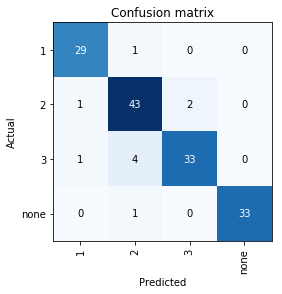

In [53]:
interp.plot_confusion_matrix()

In [0]:
losses, idxs = interp.top_losses()

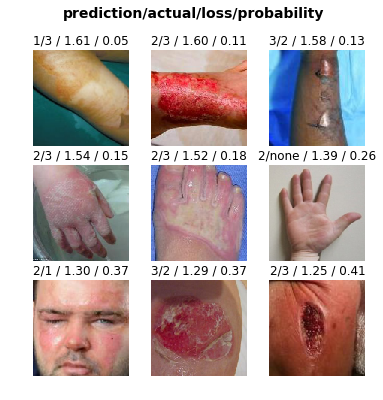

In [76]:
interp.plot_top_losses(9, figsize=(6, 6), heatmap=False)